In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
from dotenv import load_dotenv

# Load API keys from .env file 
load_dotenv(override=True)

True

# Step 1: Ingest and embed
1. Recursively load PDFs from documents\ToSort\Inspiration_folder
2. Split them into chunks
3. Generate embeddings using OpenAI
4. Save the result as a FAISS vectorstore

In [5]:
# ✅ Semantic Chunking Debug Version – Fast, Notebook-Friendly

import os
from pathlib import Path
from tqdm import tqdm
from collections import Counter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_experimental.text_splitter import SemanticChunker
from langchain_text_splitters import RecursiveCharacterTextSplitter

# 🔧 CONFIG
pdf_folder = "documents/Inspiration_folder/AIGrant_Project"
output_path = "data/embeddings/faiss_index"
use_semantic_chunking = True  # Toggle fallback

# 📥 1. Load all PDFs

def load_all_pdfs_with_metadata(folder_path, limit_pages=False):
    all_docs = []
    pdf_paths = list(Path(folder_path).rglob("*.pdf"))
    for path in tqdm(pdf_paths, desc="📄 Loading PDFs"):
        try:
            loader = PyMuPDFLoader(str(path))
            docs = loader.load()
            if limit_pages:
                docs = docs[:]  # Just first page for testing
            for doc in docs:
                doc.metadata["filename"] = path.name
                doc.metadata["source_folder"] = path.parent.name
            all_docs.extend(docs)
        except Exception as e:
            print(f"❌ Failed to load {path}: {e}")
    return all_docs

# ✂️ 2. Chunking Functions

def split_documents_semantically(docs, embeddings):
    print("🔎 Using SemanticChunker... (this may take time)")
    splitter = SemanticChunker(embeddings)
    all_chunks = []
    for doc in tqdm(docs, desc="✂️ Semantic Splitting"):
        try:
            chunks = splitter.split_documents([doc])
            all_chunks.extend(chunks)
        except Exception as e:
            print(f"⚠️ Error splitting {doc.metadata.get('filename')}: {e}")
    return all_chunks

def split_documents_recursively(docs):
    print("✂️ Using RecursiveCharacterTextSplitter...")
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
    return splitter.split_documents(docs)

# 💾 3. Save vectorstore

def save_vectorstore(chunks, embeddings):
    vectorstore = FAISS.from_documents(chunks, embeddings)
    vectorstore.save_local(output_path)
    print(f"✅ Saved FAISS vectorstore to: {output_path}")

# 🚀 Run Pipeline

def ingest_pipeline():
    print("📂 Starting pipeline...")
    docs = load_all_pdfs_with_metadata(pdf_folder, limit_pages=True)
    print(f"📄 Total docs loaded: {len(docs)}")

    folder_counts = Counter([doc.metadata["source_folder"] for doc in docs])
    print("📁 Folder distribution:")
    for k, v in folder_counts.items():
        print(f" - {k}: {v} docs")

    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

    chunks = (
        split_documents_semantically(docs, embeddings)
        if use_semantic_chunking else split_documents_recursively(docs)
    )
    print(f"🔹 Total chunks created: {len(chunks)}")

    save_vectorstore(chunks, embeddings)

if __name__ == "__main__":
    ingest_pipeline()


📂 Starting pipeline...


📄 Loading PDFs: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


📄 Total docs loaded: 4339
📁 Folder distribution:
 - Equip_Rubric: 154 docs
 - GholdyMuhammad: 180 docs
 - NGSS_Documents: 401 docs
 - OpenSciEd: 3604 docs
🔎 Using SemanticChunker... (this may take time)


✂️ Semantic Splitting: 100%|██████████| 4339/4339 [39:17<00:00,  1.84it/s]  


🔹 Total chunks created: 10271
✅ Saved FAISS vectorstore to: data/embeddings/faiss_index


# Old

📂 Loading documents...


Loading PDFs from inspiration folders: 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


📄 Total documents loaded: 401
\📁 Folder distribution in corpus:
  - test: 401 documents
✂️ Performing semantic chunking...


Splitting documents into chunks: 100%|██████████| 401/401 [03:52<00:00,  1.72it/s]


🔹 Total chunks: 927
🧠 Generating embeddings and saving vectorstore...
✅ Saved FAISS vectorstore to: data/embeddings/faiss_index
📊 Average chunk length: 1027.96 characters
🔢 Min: 1, Max: 3587


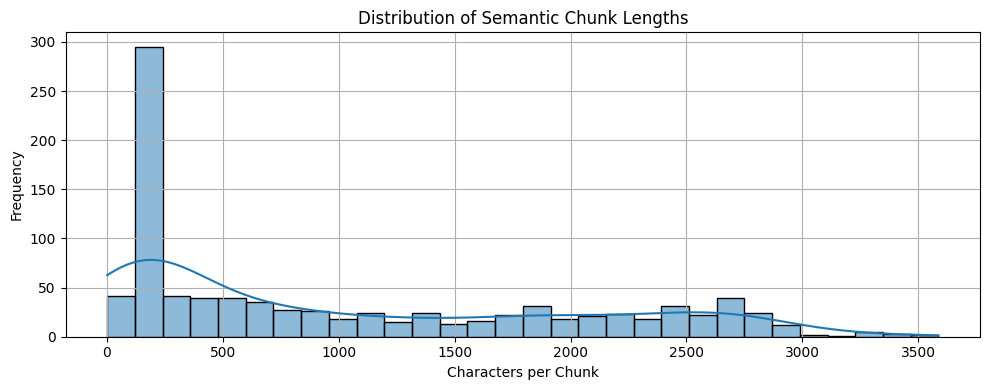

In [ ]:
# ✅ Script: Ingest PDFs, Split, Embed, and Save FAISS Vector Store
# 5 minutes on MAC
# This script loads PDF documents from a specified folder, splits them into semantic chunks, generates embeddings using OpenAI's text-embedding-3-small model, and saves the resulting vector store using FAISS.
import os
import time
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 🔧 CONFIG
pdf_folder = "documents/Inspiration_folder/test/"
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
output_path = "data/embeddings/faiss_index"

# 📥 1. Load all PDFs (recursive)
# === Load All PDFs from Subfolders ===
def load_all_pdfs_with_metadata(folder_path):
    all_docs = []
    pdf_paths = list(Path(folder_path).rglob("*.pdf"))
    for path in tqdm(pdf_paths, desc="Loading PDFs from inspiration folders"):
        try:
            loader = PyMuPDFLoader(str(path))
            docs = loader.load()
            for doc in docs:
                doc.metadata["filename"] = path.name
                doc.metadata["source_folder"] = path.parent.name
            all_docs.extend(docs)
        except Exception as e:
            print(f"Failed to load {path}: {e}")
    return all_docs

# 🧱 2. Split into chunks
def split_documents(documents):
    semantic_splitter = SemanticChunker(embedding_model, add_start_index=True)
    all_chunks = []
    for doc in tqdm(documents, desc="Splitting documents into chunks"):
        chunks = semantic_splitter.split_text(doc.page_content)
        for chunk_text in chunks:
            new_doc = doc.model_copy()
            new_doc.page_content = chunk_text
            all_chunks.append(new_doc)
    return all_chunks


# 💾 3. Save vectorstore
def save_vectorstore(chunks, embeddings, output_path):
    print("🔧 Creating FAISS vectorstore...")
    vectorstore = FAISS.from_documents(chunks, embeddings)

    
    vectorstore.save_local(output_path)
    print(f"✅ Saved FAISS vectorstore to: {output_path}")

# Assuming `chunks` is a list of Document objects with .page_content available
def log_and_visualize_chunk_lengths(chunks):
    lengths = [len(chunk.page_content) for chunk in chunks]

    print(f"📊 Average chunk length: {sum(lengths)/len(lengths):.2f} characters")
    print(f"🔢 Min: {min(lengths)}, Max: {max(lengths)}")

    # Plot distribution
    plt.figure(figsize=(10, 4))
    sns.histplot(lengths, bins=30, kde=True)
    plt.title("Distribution of Semantic Chunk Lengths")
    plt.xlabel("Characters per Chunk")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 🔄 Run pipeline
def ingest_pipeline():
    print("📂 Loading documents...")
    docs = load_all_pdfs_with_metadata(pdf_folder)
    print(f"📄 Total documents loaded: {len(docs)}")

    # Show folder distribution
    from collections import Counter
    folders = [doc.metadata.get("source_folder", "Unknown") for doc in docs]
    folder_counts = Counter(folders)
    print("\📁 Folder distribution in corpus:")
    for folder, count in folder_counts.items():
        print(f"  - {folder}: {count} documents")

    print("✂️ Performing semantic chunking...")
    chunks = split_documents(docs)
    print(f"🔹 Total chunks: {len(chunks)}")

    print("🧠 Generating embeddings and saving vectorstore...")
    save_vectorstore(chunks, embedding_model, output_path)
    log_and_visualize_chunk_lengths(chunks)
    

if __name__ == "__main__":
    ingest_pipeline()


# Analysis of average chunk length

# Step 2: Write prompts to files
1. The script write_prompts_to_files.py is now ready. When you run it, it will:
2. Create a prompts/ folder if it doesn’t exist
3. Write 3 templated prompt files:
4. unit_outline_prompt.txt
5. lesson_set_expansion_prompt.txt
6. teacher_reflection_prompt.txt

In [ ]:
# ✅ Script: Write Prompt Templates to /prompts folder

from pathlib import Path

PROMPTS = {
    "unit_outline_prompt.txt": """
You are an experienced curriculum design thinking partner for a middle school science teacher. You have 
full knowledge of creating Next Generation Science Standards (NGSS) aligned lessons supported by understanding
of the EQuIP Rubric for Lessons & Units: Science as well as Culturally Responsive Pedagogy.
Use the retrieved examples from high-quality NGSS and OpenSciEd units to help generate a general outline for a new unit.
Your task is to design a High Quality unit that is culturally relevant and responsive to the students' community context rooted in and NGSS.
Design a unit on the topic of: {topic}
Grade Level: {grade_level}
Student Context: {student_context}

As you design, consider how this unit can:
- Reflect students’ cultural identities or community experiences
- Promote inclusive participation and multiple ways of knowing in science
- Encourage relevance to students' local lives and social issues

The output should include:
1. Title of the Unit
2. NGSS Anchoring Phenomenon
3. Driving Question
4. Summary of the storyline arc (8-10 descriptive sentences in length)
5. List of 3–5 Lesson Sets (1 paragraph each)
6. List of 3–5 Key Investigations (1 paragraph each)
6. NGSS Performance Expectations (if known or retrievable)
7. Suggested Teacher Reflection Prompts

# Inspiration Context:
{context}

# Draft Unit Outline:
""",

    "lesson_set_expansion_prompt.txt": """
You are continuing the collaborative curriculum design process for a middle school science teacher.
Expand the following lesson set description into a complete lesson sequence.

Student Context: {student_context}
Grade Level: {grade_level}
Lesson Set Description: {lesson_summary}

Use examples from high-quality instructional materials to generate:
1. Lesson Titles
2. Learning Objectives
3. Key Activities or Investigations
4. Instructional Strategies and Supports
5. Assessment Opportunities
6. Optional: Opportunities for integrating cultural knowledge or community assets

# Related Context:
{context}

# Expanded Lesson Set:
""",

    "teacher_reflection_prompt.txt": """
After reviewing the generated unit plan or lesson sequence, reflect on the following:

1. How might this unit connect to students' lived experiences?
2. What voices or perspectives might be missing?
3. Are there opportunities to center local knowledge or community partnerships?
4. How does this unit reflect your values as a science educator?
"""
}

# ✍️ Save to prompts folder
def write_prompts(folder_path="prompts"):
    Path(folder_path).mkdir(parents=True, exist_ok=True)
    for filename, content in PROMPTS.items():
        with open(Path(folder_path) / filename, "w", encoding="utf-8") as f:
            f.write(content.strip())
    print(f"✅ Prompts written to: {folder_path}")

if __name__ == "__main__":
    write_prompts()


✅ Prompts written to: prompts


# Step 3: Load Prompts
1. The script Load Prompts Dynamic is ready and will:
2. Load any .txt prompt file from the prompts/ folder
3. Wrap it as a PromptTemplate for use in LangChain chains

In [6]:
# ✅ Utility Script: Load Prompt Templates from Files

from pathlib import Path
from langchain.prompts import PromptTemplate

def load_prompt_from_file(file_path: str) -> PromptTemplate:
    """Loads a prompt template from a text file and returns a LangChain PromptTemplate."""
    with open(file_path, "r", encoding="utf-8") as f:
        prompt_text = f.read()
    return PromptTemplate.from_template(prompt_text)

# Example usage:
if __name__ == "__main__":
    base_path = Path("prompts")

    unit_prompt = load_prompt_from_file(base_path / "unit_outline_prompt.txt")
    lesson_prompt = load_prompt_from_file(base_path / "lesson_set_expansion_prompt.txt")
    reflection_prompt = load_prompt_from_file(base_path / "teacher_reflection_prompt.txt")

    print("✅ Prompts loaded successfully.")
    print("\n--- Unit Outline Prompt ---\n")
    print(unit_prompt.template[:400] + "...")


✅ Prompts loaded successfully.

--- Unit Outline Prompt ---

# ✅ Updated Prompt – Unit Outline Generator with Climate Justice + Cultivating Genius

You are a curriculum design thinking partner for a middle or high school science teacher.
Use the retrieved examples from high-quality units to help generate a general outline for a new unit.

Design a unit on the topic of: {topic}
Grade Level: {grade_level}
Student Context: {student_context}

This unit should:
...


# Step 4: Teacher Outline generator
1. Prompts for topic, grade, and student context
2. Loads your custom unit design prompt
3. Pulls relevant examples using your vectorstore
4. Generates a rich outline with GPT-4
5. Saves the result as a .md file

In [8]:
# ✅ Updated Notebook Script: Teacher Input + Unit Outline Generator with JSON Output

import re
import json
from pathlib import Path
from datetime import datetime
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS

# -----------------------------
# Utility Functions
# -----------------------------
def load_prompt_from_file(prompt_path):
    with open(prompt_path, encoding="utf-8") as f:
        return PromptTemplate.from_template(f.read())

def slugify(text, max_length=60):
    slug = re.sub(r"[^a-zA-Z0-9]+", "_", text.lower()).strip("_")
    return slug[:max_length]

def extract_sections(markdown_text):
    sections = {
        "title": None,
        "phenomenon": None,
        "driving_question": None,
        "summary": None,
        "lesson_sets": [],
        "investigations": [],
        "ngss": None,
        "reflection_prompts": []
    }

    lines = markdown_text.splitlines()
    current_section = None

    for line in lines:
        line = line.strip()

        if line.startswith("1. Title"):
            current_section = "title"
        elif line.startswith("2. Anchoring Phenomenon"):
            current_section = "phenomenon"
        elif line.startswith("3. Driving Question"):
            current_section = "driving_question"
        elif line.startswith("4. Summary"):
            current_section = "summary"
        elif line.startswith("5. Lesson Sets"):
            current_section = "lesson_sets"
        elif line.startswith("6. NGSS"):
            current_section = "ngss"
        elif line.startswith("7. Suggested Teacher Reflection"):
            current_section = "reflection_prompts"
        elif current_section:
            if current_section in ["lesson_sets", "reflection_prompts"] and line.startswith("-"):
                sections[current_section].append(line[1:].strip())
            elif current_section in ["title", "phenomenon", "driving_question", "summary", "ngss"] and line:
                if not sections[current_section]:
                    sections[current_section] = line
                else:
                    sections[current_section] += f" {line}"

    return sections

# -----------------------------
# 1. Load Prompt Template
# -----------------------------
prompt_path = Path("prompts") / "unit_outline_prompt.txt"
unit_prompt = load_prompt_from_file(prompt_path)

# -----------------------------
# 2. Load Vectorstore
# -----------------------------
vectorstore_path = "data/embeddings/faiss_index"
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.load_local(
    vectorstore_path,
    embedding_model,
    allow_dangerous_deserialization=True
)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

# -----------------------------
# 3. Define LLM
# -----------------------------
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)

# -----------------------------
# 4. Create Chain
# -----------------------------
rag_chain = (
    RunnableMap({
        "context": lambda x: retriever.invoke(x["topic"]),
        "topic": lambda x: x["topic"],
        "student_context": lambda x: x["student_context"],
        "grade_level": lambda x: x.get("grade_level", "middle school")
    })
    | unit_prompt
    | llm
    | StrOutputParser()
)

# -----------------------------
# 5. Simulated Teacher Input
# -----------------------------
topic = input("🧪 What is the topic for the unit? ")
grade_level = input("🎓 What is the grade level? ")
student_context = input("👥 Describe the student/community context: ")

# -----------------------------
# 6. Run Chain and Save Output
# -----------------------------
data = {
    "topic": topic,
    "grade_level": grade_level,
    "student_context": student_context
}

print("\n🤖 Generating unit outline... Please wait...\n")
outline_response = rag_chain.invoke(data)
print("\n📝 Generated Unit Plan:\n")
print(outline_response)

# -----------------------------
# 7. Save as Markdown and JSON
# -----------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_slug = slugify(f"{topic}_{grade_level}")
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# Markdown
md_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(outline_response)

# JSON
sections = extract_sections(outline_response)
sections.update(data)
json_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(sections, f, indent=2)

print(f"\n✅ Saved unit plan to: {md_path.name}")
print(f"✅ Saved structured JSON to: {json_path.name}")



🤖 Generating unit outline... Please wait...


📝 Generated Unit Plan:

## Unit Title: Climate Justice and Local Action

### Anchoring Phenomenon
The increasing frequency and intensity of wildfires in California, particularly in local communities, and their disproportionate impact on marginalized communities.

### Driving Question
How can we use science and engineering to promote climate justice and protect vulnerable communities from the impacts of climate change?

### Introduction
On the first day, students will be introduced to the phenomenon of wildfires in California through a multimedia presentation that includes news clips, personal stories, and scientific data. This will be followed by a discussion on how these fires affect different communities, especially those that are historically marginalized. Students will be encouraged to share their own experiences or stories they have heard from family and friends.

### Storyline Arc Summary
The unit begins with an exploration of the sc

In [13]:
# ✅ Updated Notebook Script: Teacher Input + Unit Outline Generator with JSON Output

import re
import json
from pathlib import Path
from datetime import datetime
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS

# -----------------------------
# Utility Functions
# -----------------------------
def load_prompt_from_file(prompt_path):
    with open(prompt_path, encoding="utf-8") as f:
        return PromptTemplate.from_template(f.read())

def slugify(text, max_length=60):
    slug = re.sub(r"[^a-zA-Z0-9]+", "_", text.lower()).strip("_")
    return slug[:max_length]

def extract_sections(markdown_text):
    sections = {
        "title": None,
        "phenomenon": None,
        "driving_question": None,
        "summary": None,
        "lesson_sets": [],
        "investigations": [],
        "ngss": None,
        "reflection_prompts": []
    }

    lines = markdown_text.splitlines()
    current_section = None

    for line in lines:
        line = line.strip()

        # Match section headers more flexibly
        if re.match(r"^1\.\s*Title", line, re.IGNORECASE):
            current_section = "title"
        elif re.match(r"^2\.\s*Anchoring Phenomenon", line, re.IGNORECASE):
            current_section = "phenomenon"
        elif re.match(r"^3\.\s*Driving Question", line, re.IGNORECASE):
            current_section = "driving_question"
        elif re.match(r"^4\.\s*Summary", line, re.IGNORECASE):
            current_section = "summary"
        elif re.match(r"^5\.\s*Lesson Sets", line, re.IGNORECASE):
            current_section = "lesson_sets"
        elif re.match(r"^6\.\s*NGSS", line, re.IGNORECASE):
            current_section = "ngss"
        elif re.match(r"^7\.\s*Suggested Teacher Reflection", line, re.IGNORECASE):
            current_section = "reflection_prompts"
        elif current_section:
            if current_section in ["lesson_sets", "reflection_prompts", "investigations"]:
                # Accept bullets or numbered list items
                if re.match(r"^[-*]\s+", line) or re.match(r"^\d+\.\s+", line):
                    clean_text = re.sub(r"^[-*\d.]+\s+", "", line)
                    sections[current_section].append(clean_text.strip())
                elif line:
                    # Unprefixed continuation lines inside list items
                    sections[current_section].append(line.strip())
            elif current_section in ["title", "phenomenon", "driving_question", "summary", "ngss"] and line:
                if not sections[current_section]:
                    sections[current_section] = line
                else:
                    sections[current_section] += f" {line}"

    return sections


# -----------------------------
# 1. Load Prompt Template
# -----------------------------
prompt_path = Path("prompts") / "unit_outline_prompt.txt"
unit_prompt = load_prompt_from_file(prompt_path)

# -----------------------------
# 2. Load Vectorstore
# -----------------------------
vectorstore_path = "data/embeddings/faiss_index"
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.load_local(
    vectorstore_path,
    embedding_model,
    allow_dangerous_deserialization=True
)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

# -----------------------------
# 3. Define LLM
# -----------------------------
llm = ChatOpenAI(model="gpt-4", temperature=0.3)

# -----------------------------
# 4. Create Chain
# -----------------------------
rag_chain = (
    RunnableMap({
        "context": lambda x: retriever.invoke(x["topic"]),
        "topic": lambda x: x["topic"],
        "student_context": lambda x: x["student_context"],
        "grade_level": lambda x: x.get("grade_level", "middle school")
    })
    | unit_prompt
    | llm
    | StrOutputParser()
)

# -----------------------------
# 5. Simulated Teacher Input
# -----------------------------
topic = input("🧪 What is the topic for the unit? ")
grade_level = input("🎓 What is the grade level? ")
student_context = input("👥 Describe the student/community context: ")

# -----------------------------
# 6. Run Chain and Save Output
# -----------------------------
data = {
    "topic": topic,
    "grade_level": grade_level,
    "student_context": student_context
}

print("\n🤖 Generating unit outline... Please wait...\n")
outline_response = rag_chain.invoke(data)
print("\n📝 Generated Unit Plan:\n")
print(outline_response)

# -----------------------------
# 7. Save as Markdown and JSON
# -----------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_slug = slugify(f"{topic}_{grade_level}")
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# Markdown
md_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(outline_response)

# JSON
sections = extract_sections(outline_response)
sections.update(data)
json_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(sections, f, indent=2)

print(f"\n✅ Saved unit plan to: {md_path.name}")
print(f"✅ Saved structured JSON to: {json_path.name}")


🤖 Generating unit outline... Please wait...


📝 Generated Unit Plan:

1. **Title of the Unit:** "Understanding Biological Sex, Gender, and Genetic Mutations: A Biological and Sociocultural Exploration"

2. **NGSS Anchoring Phenomenon:** The variation in physical characteristics and athletic abilities among individuals due to differences in biological sex and the impact of genetic mutations.

3. **Driving Question:** How do biological sex and gender differ, and how can genetic mutations affect the development of sex characteristics and athletic performance?

4. **Summary of the Storyline Arc:** The unit begins by exploring the concepts of biological sex and gender, emphasizing their differences and societal implications. Students then delve into the role of genes in determining biological sex and how mutations can affect the development of sex characteristics. They will examine real-world examples of genetic mutations and their impacts on individuals. The unit then transitions to the i

Test fail

In [1]:
# ✅ Updated Notebook Script: Teacher Input + Unit Outline Generator with JSON Output

import re
import json
from pathlib import Path
from datetime import datetime
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS

# -----------------------------
# Utility Functions
# -----------------------------
def load_prompt_from_file(prompt_path):
    with open(prompt_path, encoding="utf-8") as f:
        return PromptTemplate.from_template(f.read())

def slugify(text, max_length=60):
    slug = re.sub(r"[^a-zA-Z0-9]+", "_", text.lower()).strip("_")
    return slug[:max_length]

def extract_sections(markdown_text):
    sections = {
        "title": None,
        "phenomenon": None,
        "driving_question": None,
        "summary": None,
        "lesson_sets": [],
        "investigations": [],
        "ngss": None,
        "reflection_prompts": []
    }

    lines = markdown_text.splitlines()
    current_section = None

    for line in lines:
        line = line.strip()

        # Directly extract inline values with colon headers
        if match := re.match(r'^1\.\s*Title of the Unit:\s*["“]?(.*)["”]?$', line):
            sections["title"] = match.group(1).strip()
            current_section = None
        elif match := re.match(r'^2\.\s*NGSS Anchoring Phenomenon:\s*(.*)$', line):
            sections["phenomenon"] = match.group(1).strip()
            current_section = None
        elif match := re.match(r'^3\.\s*Driving Question:\s*["“]?(.*)["”]?$', line):
            sections["driving_question"] = match.group(1).strip()
            current_section = None
        elif re.match(r'^4\.\s*Summary', line):
            current_section = "summary"
        elif re.match(r'^5\.\s*Lesson Sets', line):
            current_section = "lesson_sets"
        elif re.match(r'^6\.\s*Key Investigations', line):
            current_section = "investigations"
        elif re.match(r'^7\.\s*NGSS Performance Expectations', line):
            current_section = "ngss"
        elif re.match(r'^8\.\s*Suggested Teacher Reflection', line):
            current_section = "reflection_prompts"
        elif current_section:
            if current_section in ["lesson_sets", "investigations", "reflection_prompts"]:
                # Accept bulleted list items
                if re.match(r"^[-*]\s+", line):
                    clean_text = re.sub(r"^[-*]\s+", "", line)
                    sections[current_section].append(clean_text.strip())
            elif current_section in ["summary", "ngss"]:
                if not sections[current_section]:
                    sections[current_section] = line
                else:
                    sections[current_section] += f" {line}"

    return sections



# -----------------------------
# 1. Load Prompt Template
# -----------------------------
prompt_path = Path("prompts") / "unit_outline_prompt.txt"
unit_prompt = load_prompt_from_file(prompt_path)

# -----------------------------
# 2. Load Vectorstore
# -----------------------------
vectorstore_path = "data/embeddings/faiss_index"
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.load_local(
    vectorstore_path,
    embedding_model,
    allow_dangerous_deserialization=True
)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

# -----------------------------
# 3. Define LLM
# -----------------------------
llm = ChatOpenAI(model="gpt-4o", temperature=0.3)

# -----------------------------
# 4. Create Chain
# -----------------------------
rag_chain = (
    RunnableMap({
        "context": lambda x: retriever.invoke(x["topic"]),
        "topic": lambda x: x["topic"],
        "student_context": lambda x: x["student_context"],
        "grade_level": lambda x: x.get("grade_level", "middle school")
    })
    | unit_prompt
    | llm
    | StrOutputParser()
)

# -----------------------------
# 5. Simulated Teacher Input
# -----------------------------
topic = input("🧪 What is the topic for the unit? ")
grade_level = input("🎓 What is the grade level? ")
student_context = input("👥 Describe the student/community context: ")

# -----------------------------
# 6. Run Chain and Save Output
# -----------------------------
data = {
    "topic": topic,
    "grade_level": grade_level,
    "student_context": student_context
}

print("\n🤖 Generating unit outline... Please wait...\n")
outline_response = rag_chain.invoke(data)
print("\n📝 Generated Unit Plan:\n")
print(outline_response)

# -----------------------------
# 7. Save as Markdown and JSON
# -----------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_slug = slugify(f"{topic}_{grade_level}")
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# Markdown
md_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(outline_response)

# JSON
sections = extract_sections(outline_response)
sections.update(data)
json_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(sections, f, indent=2)

print(f"\n✅ Saved unit plan to: {md_path.name}")
print(f"✅ Saved structured JSON to: {json_path.name}")


🤖 Generating unit outline... Please wait...


📝 Generated Unit Plan:

**Title of the Unit:**
Climate Justice: Local Actions, Global Impact

**NGSS Anchoring Phenomenon:**
The increasing frequency and intensity of wildfires in California and their disproportionate impact on marginalized communities.

**Driving Question:**
How can we, as a community, address climate justice to mitigate the impacts of climate change on vulnerable populations in Oakland?

**Summary of the Storyline Arc:**
This unit explores the concept of climate justice through the lens of local environmental challenges and their broader global implications. Students will begin by examining the science behind climate change, focusing on the specific impacts seen in California, such as wildfires and air quality issues. They will investigate how these environmental changes disproportionately affect marginalized communities, particularly in urban areas like Oakland. Through a series of investigations, students will analyze 

test fail

In [12]:
# ✅ Updated Notebook Script: Teacher Input + Unit Outline Generator with Enhanced JSON Output

import re
import json
from pathlib import Path
from datetime import datetime
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS

# -----------------------------
# Utility Functions
# -----------------------------
def load_prompt_from_file(prompt_path):
    with open(prompt_path, encoding="utf-8") as f:
        return PromptTemplate.from_template(f.read())

def slugify(text, max_length=60):
    slug = re.sub(r"[^a-zA-Z0-9]+", "_", text.lower()).strip("_")
    return slug[:max_length]

def extract_sections(markdown_text):
    sections = {
        "title": None,
        "phenomenon": None,
        "driving_question": None,
        "summary": "",
        "lesson_sets": {},
        "investigations": {},
        "ngss": [],
        "reflection_prompts": []
    }

    current_section = None
    lines = markdown_text.splitlines()

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # Header with inline content handling
        if re.match(r"^1\.", line):
            current_section = "title"
            sections["title"] = line.split(":", 1)[1].strip().strip("\"") if ":" in line else ""
            continue
        elif re.match(r"^2\.", line):
            current_section = "phenomenon"
            sections["phenomenon"] = line.split(":", 1)[1].strip().strip("\"") if ":" in line else ""
            continue
        elif re.match(r"^3\.", line):
            current_section = "driving_question"
            sections["driving_question"] = line.split(":", 1)[1].strip().strip("\"") if ":" in line else ""
            continue
        elif re.match(r"^4\.", line):
            current_section = "summary"
            continue
        elif re.match(r"^5\.", line):
            current_section = "lesson_sets"
            continue
        elif re.match(r"^6\.", line):
            current_section = "investigations"
            continue
        elif re.match(r"^7\.", line):
            current_section = "ngss"
            continue
        elif re.match(r"^8\.", line):
            current_section = "reflection_prompts"
            continue

        if current_section in ["lesson_sets", "investigations"]:
            match = re.match(r"^[-*]?\s*(Lesson|Investigation)\s*(\d+):?\s*(.*)", line)
            if match:
                key = f"{match.group(1)} {match.group(2)}"
                val = match.group(3).strip().strip("\"")
                sections[current_section][key] = val
            else:
                match2 = re.match(r"^[-*]\s*(.*)", line)
                if match2:
                    key = f"{current_section.title()} {len(sections[current_section]) + 1}"
                    sections[current_section][key] = match2.group(1).strip("\"")

        elif current_section == "ngss":
            standards = re.findall(r"HS-[A-Z]+\d+-\d+[^-\n]*", line)
            sections["ngss"].extend(standards)

        elif current_section == "reflection_prompts":
            match = re.match(r"^[-*]\s*(.*)", line)
            if match:
                sections[current_section].append(match.group(1).strip("\""))

        elif current_section == "summary":
            sections["summary"] += line + " "

    sections["summary"] = sections["summary"].strip()
    return sections

# -----------------------------
# 1. Load Prompt Template
# -----------------------------
prompt_path = Path("prompts") / "unit_outline_prompt.txt"
unit_prompt = load_prompt_from_file(prompt_path)

# -----------------------------
# 2. Load Vectorstore
# -----------------------------
vectorstore_path = "data/embeddings/faiss_index"
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.load_local(
    vectorstore_path,
    embedding_model,
    allow_dangerous_deserialization=True
)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

# -----------------------------
# 3. Define LLM
# -----------------------------
llm = ChatOpenAI(model="gpt-4", temperature=0.3)

# -----------------------------
# 4. Create Chain
# -----------------------------
rag_chain = (
    RunnableMap({
        "context": lambda x: retriever.invoke(x["topic"]),
        "topic": lambda x: x["topic"],
        "student_context": lambda x: x["student_context"],
        "grade_level": lambda x: x.get("grade_level", "middle school")
    })
    | unit_prompt
    | llm
    | StrOutputParser()
)

# -----------------------------
# 5. Simulated Teacher Input
# -----------------------------
topic = input("🧪 What is the topic for the unit? ")
grade_level = input("🎓 What is the grade level? ")
student_context = input("👥 Describe the student/community context: ")

# -----------------------------
# 6. Run Chain and Save Output
# -----------------------------
data = {
    "topic": topic,
    "grade_level": grade_level,
    "student_context": student_context
}

print("\n🤖 Generating unit outline... Please wait...\n")
outline_response = rag_chain.invoke(data)
print("\n📝 Generated Unit Plan:\n")
print(outline_response)

# -----------------------------
# 7. Save as Markdown and JSON
# -----------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename_slug = slugify(f"{topic}_{grade_level}")
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# Markdown
md_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.md"
with open(md_path, "w", encoding="utf-8") as f:
    f.write(outline_response)

# JSON
sections = extract_sections(outline_response)
sections.update(data)
json_path = output_dir / f"unit_outline_{filename_slug}_{timestamp}.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(sections, f, indent=2)

print(f"\n✅ Saved unit plan to: {md_path.name}")
print(f"✅ Saved structured JSON to: {json_path.name}")




🤖 Generating unit outline... Please wait...


📝 Generated Unit Plan:

Unit Title: 
"Climate Justice in Our Backyard: Understanding and Addressing Environmental Inequities in Oakland"

NGSS Anchoring Phenomenon: 
Why does Oakland, a city with a significant Black and Brown population, experience more severe effects of climate change compared to other cities?

Driving Question: 
How can we leverage scientific understanding and community knowledge to combat environmental injustice and promote climate resilience in Oakland?

Unit Summary: 
In this unit, students will delve into the science behind climate change and its disproportionate impacts on communities of color, particularly in their hometown of Oakland. They will explore real-life case studies from their local area, examining how systemic racism and policy decisions have led to disparities in pollution exposure, heat stress, and access to green spaces. Students will learn how to analyze environmental data, investigate local solution

# Step 5: Lesson_expansion_generator

1. Accepts a short lesson summary
2. Pulls relevant examples using MMR search
3. Expands it into a full lesson sequence (titles, objectives, strategies, etc.)
4. Saves the output to a markdown file

In [10]:
# ✅ Lesson Expansion Script: Expand All Lesson Sets in Unit JSON

import json
from pathlib import Path
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# -----------------------------
# Config and Paths
# -----------------------------
json_file_path = "outputs/unit_outline_describe_how_biological_sex_and_gender_differ_from_each_othe_20250410_234405.json"  # UPDATE with actual filename
prompt_path = Path("prompts") / "lesson_set_expansion_prompt.txt"

# -----------------------------
# Load JSON Data from Unit Outline
# -----------------------------
with open(json_file_path, encoding="utf-8") as f:
    unit_data = json.load(f)

lesson_sets = unit_data.get("lesson_sets", {})

# -----------------------------
# Load Prompt and LLM
# -----------------------------
lesson_prompt = PromptTemplate.from_template(Path(prompt_path).read_text(encoding="utf-8"))
llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)

# -----------------------------
# Define Lesson Expansion Chain
# -----------------------------
lesson_chain = (
    RunnableMap({
        "lesson_summary": lambda x: x["lesson_summary"],
        "student_context": lambda x: x["student_context"],
        "grade_level": lambda x: x["grade_level"],
        "context": lambda x: x.get("context", "")
    })
    | lesson_prompt
    | llm
    | StrOutputParser()
)

# -----------------------------
# Expand All Lessons
# -----------------------------
all_expansions = {}

for lesson_title, lesson_summary in lesson_sets.items():
    lesson_data = {
        "lesson_summary": lesson_summary,
        "student_context": unit_data["student_context"],
        "grade_level": unit_data["grade_level"],
        "context": unit_data.get("phenomenon", "")
    }
    print(f"Expanding {lesson_title}...")
    expansion = lesson_chain.invoke(lesson_data)
    all_expansions[lesson_title] = expansion

# -----------------------------
# Save to JSON and Markdown
# -----------------------------
timestamp = json_file_path.split("unit_outline_")[1].replace(".json", "")
base_filename = f"lesson_expansions_{timestamp}"
output_dir = Path("outputs")

# Markdown
md_path = output_dir / f"{base_filename}.md"
with open(md_path, "w", encoding="utf-8") as f:
    for title, content in all_expansions.items():
        f.write(f"## {title}\n\n{content}\n\n")

# JSON
json_path = output_dir / f"{base_filename}.json"
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(all_expansions, f, indent=2)

print(f"\n✅ Saved expanded lessons to: {md_path.name}")
print(f"✅ Saved lesson JSON to: {json_path.name}")


Expanding Lesson 1...
Expanding Lesson 2...
Expanding Lesson 3...
Expanding Lesson 4...
Expanding Lesson 5...

✅ Saved expanded lessons to: lesson_expansions_describe_how_biological_sex_and_gender_differ_from_each_othe_20250410_234405.md
✅ Saved lesson JSON to: lesson_expansions_describe_how_biological_sex_and_gender_differ_from_each_othe_20250410_234405.json


In [16]:
# ✅ Updated Lesson Expansion Script 
# This code reads the "unit_outline_*.md" file from the Outline step, 
# parses out the "List of Lesson Sets", and then helps the teacher expand 
# one chosen lesson set.

import re
import sys
from pathlib import Path

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS

# 1) Load the lesson expansion prompt from file (or define inline)
def load_prompt_from_file(prompt_path: Path):
    with open(prompt_path, encoding="utf-8") as f:
        text = f.read()
    return PromptTemplate.from_template(text)

def parse_lesson_sets_from_file(filename: Path) -> str:
    """
    Tries to locate the 'List of Lesson Sets' portion from the unit outline file,
    returning them as a single text string. 
    If not found, returns empty string.
    """
    content = filename.read_text(encoding="utf-8")
    
    # A naive approach: Look for heading that says "List of Lesson Sets"
    # and read the subsequent lines up to the next heading or blank line 
    # This is just an example. You may refine or do a better parse.
    pattern = r"(List of Lesson Sets.*?)(?:\n\n|\Z)"
    match = re.search(pattern, content, flags=re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    else:
        return ""

def main():
    print("=== Lesson Expansion Script ===")

    # 2) We assume the teacher's previously generated unit outline is saved 
    # as something like "unit_outline_7th_grade.md".
    # We'll ask the teacher for that filename here or use a default:
    default_outline_file = "outputs/unit_outline_7th_grade.md"
    outline_file_str = input(f"Enter path to your unit outline markdown file [default: {default_outline_file}]: ").strip()
    if not outline_file_str:
        outline_file_str = default_outline_file
    outline_file = Path(outline_file_str)
    if not outline_file.exists():
        print(f"Error: Outline file '{outline_file}' does not exist.")
        sys.exit(1)

    # 3) Parse out the "List of Lesson Sets"
    lesson_sets_text = parse_lesson_sets_from_file(outline_file)
    if not lesson_sets_text:
        print("Warning: Could not find 'List of Lesson Sets' in the outline. The teacher may have to do this step manually.")
        print("Full file content:\n", outline_file.read_text(encoding='utf-8'))
    
    # Show teacher the lesson sets
    print("\n=== Found the following Lesson Sets portion ===\n")
    print(lesson_sets_text)
    print("\n==============================================\n")

    # 4) In your original Outline code, you might have stored the grade level & context. 
    # For demonstration, let's ask user if they want to manually specify them 
    # or parse them from the file. 
    # For now, let's just do input:
    grade_level = input("Enter the same grade level you used in the Outline step (e.g., '7th grade'): ")
    student_context = input("Enter the same student context from the outline step: ")

    # 5) Now ask teacher which lesson set they want to expand
    lesson_summary = input("Copy/paste the text for a single Lesson Set you want to expand:\n> ")

    # 6) Load the expansions prompt 
    expansions_prompt_path = Path("prompts") / "lesson_set_expansion_prompt.txt"
    lesson_expansion_prompt = load_prompt_from_file(expansions_prompt_path)

    # 7) Setup RAG if you want or if you have to retrieve from vectorstore 
    # for additional references. 
    # For demonstration, we skip or do a minimal approach:
    print("Loading Vector Store for expansions if needed ...")
    vectorstore_path = "data/embeddings/faiss_index"
    embeddings_model = ... # e.g. OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(
        vectorstore_path, 
        embeddings_model, 
        allow_dangerous_deserialization=True
    )
    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    # 8) LLM
    llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)

    # 9) Construct a chain 
    expansions_chain = (
        RunnableMap({
            "lesson_summary": lambda x: x["lesson_summary"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x["grade_level"],
            "context": lambda x: retriever.invoke("some query about expansions for " + x["lesson_summary"])
        })
        | lesson_expansion_prompt
        | llm
        | StrOutputParser()
    )

    # 10) Run the chain
    data_for_expansion = {
        "lesson_summary": lesson_summary,
        "student_context": student_context,
        "grade_level": grade_level
    }
    expansions_response = expansions_chain.invoke(data_for_expansion)
    print("\n=== EXPANDED LESSONS ===\n")
    print(expansions_response)

    # 11) Optionally save expansions
    out_dir = Path("outputs")
    out_dir.mkdir(exist_ok=True)
    expansions_file = out_dir / f"lesson_expansion_{grade_level.replace(' ','_')}.md"
    expansions_file.write_text(expansions_response, encoding='utf-8')
    print(f"\n✅ Lesson expansions saved to: {expansions_file}")

if __name__ == "__main__":
    main()


=== Lesson Expansion Script ===

=== Found the following Lesson Sets portion ===

List of Lesson Sets:
   - Lesson 1: Introduction to Biological Sex and Gender: Understanding the differences and societal implications.
   - Lesson 2: The Role of Genes in Sex Determination: Exploring the genetic basis of biological sex.
   - Lesson 3: Genetic Mutations and Variations: Examining how mutations can affect sex characteristics.
   - Lesson 4: Biological Sex Characteristics and Athletic Performance: Investigating the potential impacts on sports and competition.
   - Lesson 5: Reflecting on Gender Categories in Sports: Discussing the implications of biological sex characteristics for gender divisions in athletics.
6. NGSS Performance Expectations: 
   - HS-LS1-4: Use a model to illustrate the role of cellular division (mitosis) and differentiation in producing and maintaining complex organisms.
   - HS-LS3-1: Ask questions to clarify relationships about the role of DNA and chromosomes in coding

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


TypeError: 'ellipsis' object is not callable

# Step 6: Unit bundler
1. Select a unit outline
2. Choose one or more expanded lessons
3. Bundle them into a clean, organized .md file
4. Save it with a timestamp for version control

In [13]:
# ✅ Notebook Script: Bundle Unit Outline and Lesson Expansions into One File

from pathlib import Path
from datetime import datetime

# -----------------------------
# 1. Config Paths
# -----------------------------
outputs_dir = Path("outputs")
unit_files = list(outputs_dir.glob("unit_outline_*.md"))
lesson_files = list(outputs_dir.glob("lesson_expansion_*.md"))

# -----------------------------
# 2. Choose Unit Outline
# -----------------------------
print("📦 Available Unit Outlines:")
for i, f in enumerate(unit_files):
    print(f"[{i}] {f.name}")
unit_index = int(input("\nEnter number for unit to bundle: "))
unit_path = unit_files[unit_index]

# -----------------------------
# 3. Select Lessons to Include
# -----------------------------
print("\n📚 Available Lesson Expansions:")
for i, f in enumerate(lesson_files):
    print(f"[{i}] {f.name}")
selected_lesson_indexes = input("\nEnter numbers of lessons to include (comma separated): ")
selected_indexes = [int(i.strip()) for i in selected_lesson_indexes.split(",") if i.strip().isdigit()]
selected_lessons = [lesson_files[i] for i in selected_indexes]

# -----------------------------
# 4. Bundle Content
# -----------------------------
def read_text(path):
    return path.read_text(encoding="utf-8")

unit_text = read_text(unit_path)
lesson_texts = [read_text(p) for p in selected_lessons]

final_text = f"""
# 🧪 Bundled Science Unit Plan

## 📝 Unit Outline

{unit_text}

## 📚 Expanded Lessons

"""
for i, text in enumerate(lesson_texts):
    final_text += f"\n---\n\n### Lesson {i+1}\n{text}\n"

# -----------------------------
# 5. Save Bundled File
# -----------------------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
filename = outputs_dir / f"full_unit_plan_{timestamp}.md"
with open(filename, "w", encoding="utf-8") as f:
    f.write(final_text)

print(f"\n✅ Final bundled unit saved to: {filename}")


📦 Available Unit Outlines:
[0] unit_outline_climate_justice.md
[1] unit_outline_9th_grade_biology.md
[2] unit_outline_ecosystems_and_human_impact.md

📚 Available Lesson Expansions:
[0] lesson_expansion_climate_justice.md
[1] lesson_expansion_unit_outline_9th_grade_bi.md

✅ Final bundled unit saved to: outputs/full_unit_plan_20250410-1646.md


04 Teacher Reflection notebook is now set up!

It will:

Automatically load the most recent bundled unit

Present a series of thoughtful, CRP-aligned reflection questions

Capture teacher responses interactively

Save the reflection as a .md file for iterative documentation

This closes the loop for a powerful first cycle of your RAG tool: Inspire → Design → Expand → Bundle → Reflect

In [26]:
# ✅ Notebook Script: Teacher Reflection + Ideological Prompts

from pathlib import Path
from datetime import datetime

# -----------------------------
# 1. Load Latest Bundled Unit
# -----------------------------
outputs_dir = Path("outputs")
unit_files = sorted(outputs_dir.glob("full_unit_plan_*.md"), reverse=True)

if not unit_files:
    raise FileNotFoundError("⚠️ No bundled unit files found. Run 03_unit_bundler first.")

latest_unit_path = unit_files[0]
print(f"📄 Loaded unit file: {latest_unit_path.name}\n")

unit_text = latest_unit_path.read_text(encoding="utf-8")

# -----------------------------
# 2. Reflection Prompts
# -----------------------------
reflection_prompts = [
    "1. How might this unit connect to your students' lived experiences?",
    "2. What voices or perspectives might be missing in this unit?",
    "3. Are there opportunities to center local knowledge, language, or community assets?",
    "4. How does this unit reflect your goals and values as a science educator?",
    "5. What elements might support or challenge your existing beliefs about who science is for?",
    "6. How might this unit invite multiple ways of knowing, doing, or expressing ideas in science?"
]

# -----------------------------
# 3. Interactive Reflection Form
# -----------------------------
responses = []
print("🪞 Teacher Reflection Questions:\n")
for prompt in reflection_prompts:
    print(prompt)
    answer = input("✏️  Your thoughts: ")
    responses.append((prompt, answer))
    print("\n---\n")

# -----------------------------
# 4. Save Annotated Reflection
# -----------------------------
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
filename = outputs_dir / f"unit_reflection_{timestamp}.md"

with open(filename, "w", encoding="utf-8") as f:
    f.write("# 🧠 Teacher Reflection on Unit Design\n\n")
    f.write(f"## Based on Unit: {latest_unit_path.name}\n\n")
    f.write("\n---\n\n")
    for prompt, answer in responses:
        f.write(f"**{prompt}**\n\n{answer}\n\n")

print(f"✅ Reflection saved to: {filename}")


📄 Loaded unit file: full_unit_plan_20250402-1657.md

🪞 Teacher Reflection Questions:

1. How might this unit connect to your students' lived experiences?

---

2. What voices or perspectives might be missing in this unit?

---

3. Are there opportunities to center local knowledge, language, or community assets?

---

4. How does this unit reflect your goals and values as a science educator?

---

5. What elements might support or challenge your existing beliefs about who science is for?

---

6. How might this unit invite multiple ways of knowing, doing, or expressing ideas in science?

---

✅ Reflection saved to: outputs\unit_reflection_20250402-1702.md


Reflection Analytics / Logging
We’ll track:

Frequency of reflective responses

Sentiment or tone (e.g. using a simple NLP classifier)

Shifts in ideology or themes over time across units

Load all saved reflections

Analyze each response for sentiment (via TextBlob)

Visualize trends across prompts

Save the full dataset as a .csv for deeper qualitative or longitudinal analysis

In [ ]:
# ✅ Notebook Script: Analyze Teacher Reflections for Growth & Themes

from pathlib import Path
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Reflections
# -----------------------------
outputs_dir = Path("outputs")
reflection_files = sorted(outputs_dir.glob("unit_reflection_*.md"))

if not reflection_files:
    raise FileNotFoundError("⚠️ No reflection files found. Run 04_teacher_reflection first.")

reflection_data = []
for file in reflection_files:
    text = file.read_text(encoding="utf-8")
    lines = text.splitlines()
    for i, line in enumerate(lines):
        if line.startswith("**") and i + 1 < len(lines):
            question = line.strip("* ")
            response = lines[i + 1].strip()
            reflection_data.append({
                "file": file.name,
                "question": question,
                "response": response
            })

df = pd.DataFrame(reflection_data)
print(f"✅ Loaded {len(df)} reflection responses from {len(reflection_files)} files.")

# -----------------------------
# 2. Sentiment Analysis
# -----------------------------
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df["sentiment"] = df["response"].apply(get_sentiment)

# -----------------------------
# 3. Display Summary Stats
# -----------------------------
print("\n📊 Sentiment Summary by Question:")
print(df.groupby("question")["sentiment"].mean().round(2))

# -----------------------------
# 4. Visualization
# -----------------------------
plt.figure(figsize=(10, 6))
df.boxplot(column="sentiment", by="question", rot=45)
plt.title("Sentiment by Reflection Question")
plt.suptitle("")
plt.ylabel("Sentiment Polarity (-1 to 1)")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()

# -----------------------------
# 5. Export as CSV (optional)
# -----------------------------
df.to_csv(outputs_dir / "reflection_analysis.csv", index=False)
print("\n📁 Saved raw reflection data to: reflection_analysis.csv")


Export PDF
06_export_pdf_doc will:

Grab your most recent bundled unit and reflection

Export them to both PDF (via fpdf) and Word/Google Doc format (via python-docx)

Keep everything organized in your outputs/ folder

In [ ]:
# ✅ Notebook Script: Export Bundled Unit and Reflection to PDF or Google Doc

from pathlib import Path
from datetime import datetime
from fpdf import FPDF
import markdown2

# -----------------------------
# 1. Load Most Recent Files
# -----------------------------
outputs_dir = Path("outputs")
unit_file = sorted(outputs_dir.glob("full_unit_plan_*.md"), reverse=True)[0]
reflection_file = sorted(outputs_dir.glob("unit_reflection_*.md"), reverse=True)[0]

unit_text = unit_file.read_text(encoding="utf-8")
reflection_text = reflection_file.read_text(encoding="utf-8")

# -----------------------------
# 2. Convert Markdown to HTML (for reference)
# -----------------------------
html_unit = markdown2.markdown(unit_text)
html_reflection = markdown2.markdown(reflection_text)

# -----------------------------
# 3. Convert to PDF using FPDF
# -----------------------------
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, "Bundled Science Unit + Reflection", ln=True, align="C")
        self.ln(5)

    def chapter_title(self, title):
        self.set_font("Arial", "B", 11)
        self.cell(0, 10, title, ln=True)
        self.ln(4)

    def chapter_body(self, text):
        self.set_font("Arial", size=10)
        self.multi_cell(0, 6, text)
        self.ln()

pdf = PDF()
pdf.add_page()
pdf.chapter_title("Unit Plan")
pdf.chapter_body(unit_text)
pdf.chapter_title("Teacher Reflection")
pdf.chapter_body(reflection_text)

pdf_file = outputs_dir / f"unit_bundle_export_{datetime.now().strftime('%Y%m%d-%H%M')}.pdf"
pdf.output(str(pdf_file))

print(f"✅ PDF exported to: {pdf_file}")

# -----------------------------
# 4. Google Docs (Optional, Outline Only)
# -----------------------------
try:
    from docx import Document
    doc = Document()
    doc.add_heading("Bundled Science Unit + Teacher Reflection", 0)

    doc.add_heading("Unit Plan", level=1)
    doc.add_paragraph(unit_text)

    doc.add_heading("Teacher Reflection", level=1)
    doc.add_paragraph(reflection_text)

    docx_file = outputs_dir / f"unit_bundle_export_{datetime.now().strftime('%Y%m%d-%H%M')}.docx"
    doc.save(docx_file)
    print(f"✅ Word Doc exported to: {docx_file}")

except ImportError:
    print("⚠️ To enable Word/Google Docs export, run: pip install python-docx")


07 Teacher interface App

 unified Streamlit app is now ready in 07_teacher_interface_app.py!

This prototype lets teachers:

Input a topic, grade, and student context

Generate a culturally responsive unit outline with RAG + GPT-4

View the result in-browser and save it automatically

In [2]:
# ✅ Updated Unified Teacher-Facing App – Streamlit Prototype

import streamlit as st
from pathlib import Path
from datetime import datetime
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

# Assume a utility function for loading prompts
def load_prompt_from_file(prompt_path):
    with open(prompt_path, encoding="utf-8") as f:
        return PromptTemplate.from_template(f.read())

# -----------------------------
# 1. App Config
# -----------------------------
st.set_page_config(page_title="Curriculum CoDesigner", layout="centered")
st.title("🧠 Curriculum CoDesigner – AI Thinking Partner")

# -----------------------------
# 2. Input from Teacher
# -----------------------------
with st.form("unit_form"):
    topic = st.text_input("Unit Topic (e.g., Climate Change)", "ecosystems and human impact")
    grade = st.selectbox("Grade Level", ["6th", "7th", "8th", "middle school"])
    context = st.text_area("Describe your students or community context", "Black and Latinx students in Los Angeles")
    submitted = st.form_submit_button("Generate Unit Outline")

# -----------------------------
# 3. Setup RAG Components
# -----------------------------
if submitted:
    st.info("Loading models and retriever...")

    prompt_path = Path("prompts") / "unit_outline_prompt.txt"
    unit_prompt = load_prompt_from_file(prompt_path)

    vectorstore_path = "data/embeddings/faiss_index"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(vectorstore_path, embeddings, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    llm = ChatOpenAI(model="gpt-4", temperature=0.3)

    rag_chain = (
        RunnableMap({
            "context": lambda x: retriever.invoke(x["topic"]),
            "topic": lambda x: x["topic"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x.get("grade_level", "middle school")
        })
        | unit_prompt
        | llm
        | StrOutputParser()
    )

    data = {
        "topic": topic,
        "student_context": context,
        "grade_level": grade
    }

    st.success("Generating unit outline... Please wait ⏳")
    unit_output = rag_chain.invoke(data)

    # Display
    st.subheader("📘 Draft Unit Outline")
    st.markdown(unit_output)

    # Save
    output_dir = Path("outputs")
    output_dir.mkdir(exist_ok=True)
    filename = output_dir / f"unit_outline_{topic.replace(' ', '_')}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write(unit_output)
    st.success(f"✅ Saved to: {filename.name}")


2025-04-03 11:03:19.225 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-03 11:03:19.227 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-03 11:03:19.340 
  command:

    streamlit run c:\Users\mrhal\anaconda3\envs\ragtest1-env\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-03 11:03:19.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-03 11:03:19.342 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-03 11:03:19.343 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-03 11:03:19.343 Thread 'MainThread': missing ScriptRunContext! This warning can be

File Upload
Teachers can now:

Upload custom PDFs (e.g., low-quality or local lessons)

Have those documents instantly split, embedded, and used for RAG generation

Fall back to your core inspiration corpus if no files are uploaded

In [ ]:
# ✅ Unified Teacher-Facing App – Streamlit Prototype with File Uploads

import streamlit as st
from pathlib import Path
from datetime import datetime
from utils.load_prompts import load_prompt_from_file
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# -----------------------------
# 1. App Config
# -----------------------------
st.set_page_config(page_title="Curriculum CoDesigner", layout="centered")
st.title("🧠 Curriculum CoDesigner – AI Thinking Partner")

# -----------------------------
# 2. File Upload Section
# -----------------------------
with st.expander("📁 Upload Custom Documents (optional)"):
    uploaded_files = st.file_uploader("Upload PDFs for inspiration (e.g., existing lessons)", type="pdf", accept_multiple_files=True)
    temp_dir = Path("data/uploads")
    temp_dir.mkdir(parents=True, exist_ok=True)

    custom_docs = []
    if uploaded_files:
        for file in uploaded_files:
            file_path = temp_dir / file.name
            with open(file_path, "wb") as f:
                f.write(file.read())
            loader = PyMuPDFLoader(str(file_path))
            docs = loader.load()
            splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
            split_docs = splitter.split_documents(docs)
            custom_docs.extend(split_docs)
        st.success(f"✅ Loaded and split {len(custom_docs)} chunks from uploaded PDFs.")

# -----------------------------
# 3. Input from Teacher
# -----------------------------
with st.form("unit_form"):
    topic = st.text_input("Unit Topic (e.g., Climate Change)", "ecosystems and human impact")
    grade = st.selectbox("Grade Level", ["6th", "7th", "8th", "middle school"])
    context = st.text_area("Describe your students or community context", "Black and Latinx students in Los Angeles")
    submitted = st.form_submit_button("Generate Unit Outline")

# -----------------------------
# 4. Setup RAG Components
# -----------------------------
if submitted:
    st.info("Loading models and retriever...")

    prompt_path = Path("prompts") / "unit_outline_prompt.txt"
    unit_prompt = load_prompt_from_file(prompt_path)

    vectorstore_path = "data/embeddings/faiss_index"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(vectorstore_path, embeddings)

    if custom_docs:
        custom_vectorstore = FAISS.from_documents(custom_docs, embeddings)
        retriever = custom_vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})
    else:
        retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)

    rag_chain = (
        RunnableMap({
            "context": lambda x: retriever.invoke(x["topic"]),
            "topic": lambda x: x["topic"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x.get("grade_level", "middle school")
        })
        | unit_prompt
        | llm
        | StrOutputParser()
    )

    data = {
        "topic": topic,
        "student_context": context,
        "grade_level": grade
    }

    st.success("Generating unit outline... Please wait ⏳")
    unit_output = rag_chain.invoke(data)

    # Display
    st.subheader("📘 Draft Unit Outline")
    st.markdown(unit_output)

    # Save
    output_dir = Path("outputs")
    output_dir.mkdir(exist_ok=True)
    filename = output_dir / f"unit_outline_{topic.replace(' ', '_')}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write(unit_output)
    st.success(f"✅ Saved to: {filename.name}")

Add CRP reflection prompts

Streamlit app now includes built-in CRP reflection prompts!

After a unit outline is generated, teachers are guided to reflect on:

Cultural relevance

Epistemological diversity

Local significance

Equity-related uncertainties

Reflections are saved per unit alongside the design.

In [ ]:
# ✅ Unified Teacher-Facing App – Streamlit Prototype with File Uploads + Reflection Prompts

import streamlit as st
from pathlib import Path
from datetime import datetime
from utils.load_prompts import load_prompt_from_file
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# -----------------------------
# 1. App Config
# -----------------------------
st.set_page_config(page_title="Curriculum CoDesigner", layout="centered")
st.title("🧠 Curriculum CoDesigner – AI Thinking Partner")

# -----------------------------
# 2. File Upload Section
# -----------------------------
with st.expander("📁 Upload Custom Documents (optional)"):
    uploaded_files = st.file_uploader("Upload PDFs for inspiration (e.g., existing lessons)", type="pdf", accept_multiple_files=True)
    temp_dir = Path("data/uploads")
    temp_dir.mkdir(parents=True, exist_ok=True)

    custom_docs = []
    if uploaded_files:
        for file in uploaded_files:
            file_path = temp_dir / file.name
            with open(file_path, "wb") as f:
                f.write(file.read())
            loader = PyMuPDFLoader(str(file_path))
            docs = loader.load()
            splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
            split_docs = splitter.split_documents(docs)
            custom_docs.extend(split_docs)
        st.success(f"✅ Loaded and split {len(custom_docs)} chunks from uploaded PDFs.")

# -----------------------------
# 3. Input from Teacher
# -----------------------------
with st.form("unit_form"):
    topic = st.text_input("Unit Topic (e.g., Climate Change)", "ecosystems and human impact")
    grade = st.selectbox("Grade Level", ["6th", "7th", "8th", "middle school"])
    context = st.text_area("Describe your students or community context", "Black and Latinx students in Los Angeles")
    submitted = st.form_submit_button("Generate Unit Outline")

# -----------------------------
# 4. Setup RAG Components
# -----------------------------
if submitted:
    st.info("Loading models and retriever...")

    prompt_path = Path("prompts") / "unit_outline_prompt.txt"
    unit_prompt = load_prompt_from_file(prompt_path)

    vectorstore_path = "data/embeddings/faiss_index"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(vectorstore_path, embeddings)

    if custom_docs:
        custom_vectorstore = FAISS.from_documents(custom_docs, embeddings)
        retriever = custom_vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})
    else:
        retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)

    rag_chain = (
        RunnableMap({
            "context": lambda x: retriever.invoke(x["topic"]),
            "topic": lambda x: x["topic"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x.get("grade_level", "middle school")
        })
        | unit_prompt
        | llm
        | StrOutputParser()
    )

    data = {
        "topic": topic,
        "student_context": context,
        "grade_level": grade
    }

    st.success("Generating unit outline... Please wait ⏳")
    unit_output = rag_chain.invoke(data)

    # Display
    st.subheader("📘 Draft Unit Outline")
    st.markdown(unit_output)

    # Save
    output_dir = Path("outputs")
    output_dir.mkdir(exist_ok=True)
    filename = output_dir / f"unit_outline_{topic.replace(' ', '_')}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write(unit_output)
    st.success(f"✅ Saved to: {filename.name}")

    # -----------------------------
    # 5. CRP Reflection Prompts
    # -----------------------------
    st.subheader("🪞 Teacher Reflection")
    st.markdown("Please respond to the following questions to reflect on your design:")

    with st.form("reflection_form"):
        q1 = st.text_area("1. How does this unit reflect the cultural identities or experiences of your students?")
        q2 = st.text_area("2. Where could students bring in multiple ways of knowing (cultural, linguistic, experiential)?")
        q3 = st.text_area("3. What might make this more locally relevant or socially meaningful?")
        q4 = st.text_area("4. What questions do you still have about how to support equity in this unit?")
        save_reflection = st.form_submit_button("💾 Save Reflection")

    if save_reflection:
        reflection_text = f"""
**Reflection for Unit: {topic}**

**1. Cultural Identities:**
{q1}

**2. Multiple Ways of Knowing:**
{q2}

**3. Local Relevance:**
{q3}

**4. Open Questions:**
{q4}
"""
        reflection_file = output_dir / f"unit_reflection_{topic.replace(' ', '_')}.md"
        with open(reflection_file, "w", encoding="utf-8") as f:
            f.write(reflection_text)
        st.success(f"✅ Reflection saved to: {reflection_file.name}")


Lesson expansion is now built into the Streamlit app!

After generating the unit outline, teachers can:

Select how many lessons they want (2–10)

Automatically generate detailed lesson-level plans

Save and view those lessons in-browser

In [15]:
# ✅ Unified Teacher-Facing App – Streamlit Prototype with File Uploads + Reflection Prompts + Lesson Expansion

import streamlit as st
from pathlib import Path
from datetime import datetime
from utils.load_prompts import load_prompt_from_file
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# -----------------------------
# 1. App Config
# -----------------------------
st.set_page_config(page_title="Curriculum CoDesigner", layout="centered")
st.title("🧠 Curriculum CoDesigner – AI Thinking Partner")

# -----------------------------
# 2. File Upload Section
# -----------------------------
with st.expander("📁 Upload Custom Documents (optional)"):
    uploaded_files = st.file_uploader("Upload PDFs for inspiration (e.g., existing lessons)", type="pdf", accept_multiple_files=True)
    temp_dir = Path("data/uploads")
    temp_dir.mkdir(parents=True, exist_ok=True)

    custom_docs = []
    if uploaded_files:
        for file in uploaded_files:
            file_path = temp_dir / file.name
            with open(file_path, "wb") as f:
                f.write(file.read())
            loader = PyMuPDFLoader(str(file_path))
            docs = loader.load()
            splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
            split_docs = splitter.split_documents(docs)
            custom_docs.extend(split_docs)
        st.success(f"✅ Loaded and split {len(custom_docs)} chunks from uploaded PDFs.")

# -----------------------------
# 3. Input from Teacher
# -----------------------------
with st.form("unit_form"):
    topic = st.text_input("Unit Topic (e.g., Climate Change)", "ecosystems and human impact")
    grade = st.selectbox("Grade Level", ["6th", "7th", "8th", "middle school"])
    context = st.text_area("Describe your students or community context", "Black and Latinx students in Los Angeles")
    submitted = st.form_submit_button("Generate Unit Outline")

# -----------------------------
# 4. Setup RAG Components
# -----------------------------
if submitted:
    st.info("Loading models and retriever...")

    prompt_path = Path("prompts") / "unit_outline_prompt.txt"
    unit_prompt = load_prompt_from_file(prompt_path)

    lesson_path = Path("prompts") / "lesson_expander_prompt.txt"
    lesson_prompt = load_prompt_from_file(lesson_path)

    vectorstore_path = "data/embeddings/faiss_index"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(vectorstore_path, embeddings)

    if custom_docs:
        custom_vectorstore = FAISS.from_documents(custom_docs, embeddings)
        retriever = custom_vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})
    else:
        retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)

    rag_chain = (
        RunnableMap({
            "context": lambda x: retriever.invoke(x["topic"]),
            "topic": lambda x: x["topic"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x.get("grade_level", "middle school")
        })
        | unit_prompt
        | llm
        | StrOutputParser()
    )

    data = {
        "topic": topic,
        "student_context": context,
        "grade_level": grade
    }

    st.success("Generating unit outline... Please wait ⏳")
    unit_output = rag_chain.invoke(data)

    # Display
    st.subheader("📘 Draft Unit Outline")
    st.markdown(unit_output)

    # Save
    output_dir = Path("outputs")
    output_dir.mkdir(exist_ok=True)
    filename = output_dir / f"unit_outline_{topic.replace(' ', '_')}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write(unit_output)
    st.success(f"✅ Saved to: {filename.name}")

    # -----------------------------
    # 5. Lesson Expansion Prompt
    # -----------------------------
    st.subheader("📚 Expand Unit into Detailed Lessons")
    with st.form("lesson_form"):
        num_lessons = st.slider("How many lessons would you like to expand into?", 2, 10, 4)
        expand_button = st.form_submit_button("Expand Lessons")

    if expand_button:
        lesson_chain = (
            RunnableMap({
                "unit_outline": lambda x: unit_output,
                "topic": lambda x: x["topic"],
                "num_lessons": lambda x: x["num_lessons"]
            })
            | lesson_prompt
            | llm
            | StrOutputParser()
        )

        lesson_data = {"topic": topic, "num_lessons": num_lessons}
        expanded_lessons = lesson_chain.invoke(lesson_data)
        st.markdown(expanded_lessons)

        expanded_file = output_dir / f"lesson_expansion_{topic.replace(' ', '_')}.md"
        with open(expanded_file, "w", encoding="utf-8") as f:
            f.write(expanded_lessons)
        st.success(f"✅ Expanded lessons saved to: {expanded_file.name}")

    # -----------------------------
    # 6. CRP Reflection Prompts
    # -----------------------------
    st.subheader("🪞 Teacher Reflection")
    st.markdown("Please respond to the following questions to reflect on your design:")

    with st.form("reflection_form"):
        q1 = st.text_area("1. How does this unit reflect the cultural identities or experiences of your students?")
        q2 = st.text_area("2. Where could students bring in multiple ways of knowing (cultural, linguistic, experiential)?")
        q3 = st.text_area("3. What might make this more locally relevant or socially meaningful?")
        q4 = st.text_area("4. What questions do you still have about how to support equity in this unit?")
        save_reflection = st.form_submit_button("💾 Save Reflection")

    if save_reflection:
        reflection_text = f"""
**Reflection for Unit: {topic}**

**1. Cultural Identities:**
{q1}

**2. Multiple Ways of Knowing:**
{q2}

**3. Local Relevance:**
{q3}

**4. Open Questions:**
{q4}
"""
        reflection_file = output_dir / f"unit_reflection_{topic.replace(' ', '_')}.md"
        with open(reflection_file, "w", encoding="utf-8") as f:
            f.write(reflection_text)
        st.success(f"✅ Reflection saved to: {reflection_file.name}")


ModuleNotFoundError: No module named 'utils'

PDF export added! After reflection is submitted, your app now:

Combines unit outline, lessons, and reflection into one PDF

Saves and displays a download button for easy access

In [ ]:
# ✅ Unified Teacher-Facing App – Streamlit Prototype with File Uploads + Reflection Prompts + Lesson Expansion + PDF Export

import streamlit as st
from pathlib import Path
from datetime import datetime
from utils.load_prompts import load_prompt_from_file
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from fpdf import FPDF

# -----------------------------
# 1. App Config
# -----------------------------
st.set_page_config(page_title="Curriculum CoDesigner", layout="centered")
st.title("🧠 Curriculum CoDesigner – AI Thinking Partner")

# -----------------------------
# 2. File Upload Section
# -----------------------------
with st.expander("📁 Upload Custom Documents (optional)"):
    uploaded_files = st.file_uploader("Upload PDFs for inspiration (e.g., existing lessons)", type="pdf", accept_multiple_files=True)
    temp_dir = Path("data/uploads")
    temp_dir.mkdir(parents=True, exist_ok=True)

    custom_docs = []
    if uploaded_files:
        for file in uploaded_files:
            file_path = temp_dir / file.name
            with open(file_path, "wb") as f:
                f.write(file.read())
            loader = PyMuPDFLoader(str(file_path))
            docs = loader.load()
            splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
            split_docs = splitter.split_documents(docs)
            custom_docs.extend(split_docs)
        st.success(f"✅ Loaded and split {len(custom_docs)} chunks from uploaded PDFs.")

# -----------------------------
# 3. Input from Teacher
# -----------------------------
with st.form("unit_form"):
    topic = st.text_input("Unit Topic (e.g., Climate Change)", "ecosystems and human impact")
    grade = st.selectbox("Grade Level", ["6th", "7th", "8th", "middle school"])
    context = st.text_area("Describe your students or community context", "Black and Latinx students in Los Angeles")
    submitted = st.form_submit_button("Generate Unit Outline")

# -----------------------------
# 4. Setup RAG Components
# -----------------------------
if submitted:
    st.info("Loading models and retriever...")

    prompt_path = Path("prompts") / "unit_outline_prompt.txt"
    unit_prompt = load_prompt_from_file(prompt_path)

    lesson_path = Path("prompts") / "lesson_expander_prompt.txt"
    lesson_prompt = load_prompt_from_file(lesson_path)

    vectorstore_path = "data/embeddings/faiss_index"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(vectorstore_path, embeddings)

    if custom_docs:
        custom_vectorstore = FAISS.from_documents(custom_docs, embeddings)
        retriever = custom_vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})
    else:
        retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)

    rag_chain = (
        RunnableMap({
            "context": lambda x: retriever.invoke(x["topic"]),
            "topic": lambda x: x["topic"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x.get("grade_level", "middle school")
        })
        | unit_prompt
        | llm
        | StrOutputParser()
    )

    data = {
        "topic": topic,
        "student_context": context,
        "grade_level": grade
    }

    st.success("Generating unit outline... Please wait ⏳")
    unit_output = rag_chain.invoke(data)

    # Display
    st.subheader("📘 Draft Unit Outline")
    st.markdown(unit_output)

    # Save
    output_dir = Path("outputs")
    output_dir.mkdir(exist_ok=True)
    filename = output_dir / f"unit_outline_{topic.replace(' ', '_')}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write(unit_output)
    st.success(f"✅ Saved to: {filename.name}")

    # -----------------------------
    # 5. Lesson Expansion Prompt
    # -----------------------------
    st.subheader("📚 Expand Unit into Detailed Lessons")
    with st.form("lesson_form"):
        num_lessons = st.slider("How many lessons would you like to expand into?", 2, 10, 4)
        expand_button = st.form_submit_button("Expand Lessons")

    if expand_button:
        lesson_chain = (
            RunnableMap({
                "unit_outline": lambda x: unit_output,
                "topic": lambda x: x["topic"],
                "num_lessons": lambda x: x["num_lessons"]
            })
            | lesson_prompt
            | llm
            | StrOutputParser()
        )

        lesson_data = {"topic": topic, "num_lessons": num_lessons}
        expanded_lessons = lesson_chain.invoke(lesson_data)
        st.markdown(expanded_lessons)

        expanded_file = output_dir / f"lesson_expansion_{topic.replace(' ', '_')}.md"
        with open(expanded_file, "w", encoding="utf-8") as f:
            f.write(expanded_lessons)
        st.success(f"✅ Expanded lessons saved to: {expanded_file.name}")

    # -----------------------------
    # 6. CRP Reflection Prompts
    # -----------------------------
    st.subheader("🪞 Teacher Reflection")
    st.markdown("Please respond to the following questions to reflect on your design:")

    with st.form("reflection_form"):
        q1 = st.text_area("1. How does this unit reflect the cultural identities or experiences of your students?")
        q2 = st.text_area("2. Where could students bring in multiple ways of knowing (cultural, linguistic, experiential)?")
        q3 = st.text_area("3. What might make this more locally relevant or socially meaningful?")
        q4 = st.text_area("4. What questions do you still have about how to support equity in this unit?")
        save_reflection = st.form_submit_button("💾 Save Reflection")

    if save_reflection:
        reflection_text = f"""
**Reflection for Unit: {topic}**

**1. Cultural Identities:**
{q1}

**2. Multiple Ways of Knowing:**
{q2}

**3. Local Relevance:**
{q3}

**4. Open Questions:**
{q4}
"""
        reflection_file = output_dir / f"unit_reflection_{topic.replace(' ', '_')}.md"
        with open(reflection_file, "w", encoding="utf-8") as f:
            f.write(reflection_text)
        st.success(f"✅ Reflection saved to: {reflection_file.name}")

        # Export to PDF
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)
        for line in (unit_output + "\n" + expanded_lessons + "\n" + reflection_text).split("\n"):
            pdf.multi_cell(0, 10, line)
        pdf_filename = output_dir / f"unit_bundle_{topic.replace(' ', '_')}.pdf"
        pdf.output(str(pdf_filename))
        with open(pdf_filename, "rb") as f:
            st.download_button("📄 Download Full Unit PDF", data=f, file_name=pdf_filename.name)
        st.success("📁 Full unit PDF exported!")


Review and export
 Review & Export tab is now live! You can:

See the full unit + lessons + reflection all together

Download it as a bundled PDF

In [ ]:
# ✅ Unified Teacher-Facing App – Streamlit Prototype with Review + Export Page

import streamlit as st
from pathlib import Path
from datetime import datetime
from utils.load_prompts import load_prompt_from_file
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from fpdf import FPDF

st.set_page_config(page_title="Curriculum CoDesigner", layout="centered")
st.title("🧠 Curriculum CoDesigner – AI Thinking Partner")

# -----------------------------
# App State & Session Storage
# -----------------------------
if "unit_output" not in st.session_state:
    st.session_state.unit_output = ""
if "expanded_lessons" not in st.session_state:
    st.session_state.expanded_lessons = ""
if "reflection_text" not in st.session_state:
    st.session_state.reflection_text = ""

# -----------------------------
# Step-by-step workflow
# -----------------------------
st.sidebar.title("Navigation")
page = st.sidebar.radio("Go to:", ["1️⃣ Upload & Inputs", "2️⃣ Unit Builder", "3️⃣ Lesson Expansion", "4️⃣ Reflection", "5️⃣ Review & Export"])

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# -----------------------------
# Page 1: Upload & Inputs
# -----------------------------
if page == "1️⃣ Upload & Inputs":
    with st.expander("📁 Upload Custom Documents (optional)"):
        uploaded_files = st.file_uploader("Upload PDFs for inspiration", type="pdf", accept_multiple_files=True)
        temp_dir = Path("data/uploads")
        temp_dir.mkdir(parents=True, exist_ok=True)

        st.session_state.custom_docs = []
        if uploaded_files:
            for file in uploaded_files:
                file_path = temp_dir / file.name
                with open(file_path, "wb") as f:
                    f.write(file.read())
                loader = PyMuPDFLoader(str(file_path))
                docs = loader.load()
                splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
                split_docs = splitter.split_documents(docs)
                st.session_state.custom_docs.extend(split_docs)
            st.success(f"✅ Loaded {len(st.session_state.custom_docs)} chunks from PDFs.")

    with st.form("unit_form"):
        st.session_state.topic = st.text_input("Unit Topic", "ecosystems and human impact")
        st.session_state.grade = st.selectbox("Grade Level", ["6th", "7th", "8th", "middle school"])
        st.session_state.context = st.text_area("Describe your student/community context", "Black and Latinx students in LA")
        st.session_state.submit_inputs = st.form_submit_button("Generate Unit Outline")

# -----------------------------
# Page 2: Unit Builder
# -----------------------------
if page == "2️⃣ Unit Builder" and st.session_state.get("submit_inputs"):
    st.info("🔄 Generating outline using your topic and context...")
    unit_prompt = load_prompt_from_file(Path("prompts") / "unit_outline_prompt.txt")
    vectorstore_path = "data/embeddings/faiss_index"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(vectorstore_path, embeddings)

    if st.session_state.get("custom_docs"):
        custom_vectorstore = FAISS.from_documents(st.session_state.custom_docs, embeddings)
        retriever = custom_vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})
    else:
        retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)
    rag_chain = (
        RunnableMap({
            "context": lambda x: retriever.invoke(x["topic"]),
            "topic": lambda x: x["topic"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x.get("grade_level", "middle school")
        })
        | unit_prompt
        | llm
        | StrOutputParser()
    )
    data = {
        "topic": st.session_state.topic,
        "student_context": st.session_state.context,
        "grade_level": st.session_state.grade
    }
    st.session_state.unit_output = rag_chain.invoke(data)
    st.subheader("📘 Generated Unit Outline")
    st.markdown(st.session_state.unit_output)

# -----------------------------
# Page 3: Lesson Expansion
# -----------------------------
if page == "3️⃣ Lesson Expansion" and st.session_state.unit_output:
    st.subheader("📚 Expand Into Lessons")
    with st.form("lesson_form"):
        num_lessons = st.slider("Number of lessons", 2, 10, 4)
        expand_button = st.form_submit_button("Expand Lessons")

    if expand_button:
        lesson_prompt = load_prompt_from_file(Path("prompts") / "lesson_expander_prompt.txt")
        llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)
        lesson_chain = (
            RunnableMap({
                "unit_outline": lambda x: st.session_state.unit_output,
                "topic": lambda x: st.session_state.topic,
                "num_lessons": lambda x: x["num_lessons"]
            })
            | lesson_prompt
            | llm
            | StrOutputParser()
        )
        lesson_data = {"num_lessons": num_lessons}
        st.session_state.expanded_lessons = lesson_chain.invoke(lesson_data)
        st.markdown(st.session_state.expanded_lessons)

# -----------------------------
# Page 4: Reflection
# -----------------------------
if page == "4️⃣ Reflection" and st.session_state.expanded_lessons:
    st.subheader("🪞 Teacher Reflection")
    with st.form("reflection_form"):
        q1 = st.text_area("1. How does this unit reflect the cultural identities of your students?")
        q2 = st.text_area("2. Where can students bring in multiple ways of knowing?")
        q3 = st.text_area("3. What could make this more locally meaningful?")
        q4 = st.text_area("4. What are open questions you still have about equity in this unit?")
        submit_reflection = st.form_submit_button("💾 Save Reflection")

    if submit_reflection:
        st.session_state.reflection_text = f"""
**Reflection for Unit: {st.session_state.topic}**

**1. Cultural Identities:**
{q1}

**2. Multiple Ways of Knowing:**
{q2}

**3. Local Relevance:**
{q3}

**4. Open Questions:**
{q4}
"""
        st.success("✅ Reflection saved. Proceed to Review & Export tab.")

# -----------------------------
# Page 5: Review and Export
# -----------------------------
if page == "5️⃣ Review & Export" and st.session_state.unit_output and st.session_state.expanded_lessons:
    st.subheader("📦 Review Final Bundle")
    st.markdown("### 🧾 Unit Plan")
    st.markdown(st.session_state.unit_output)
    st.markdown("### 🧩 Lessons")
    st.markdown(st.session_state.expanded_lessons)
    st.markdown("### 🪞 Reflection")
    st.markdown(st.session_state.reflection_text)

    full_text = f"""
{st.session_state.unit_output}

{st.session_state.expanded_lessons}

{st.session_state.reflection_text}
"""
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    for line in full_text.split("\n"):
        pdf.multi_cell(0, 10, line)
    filename = output_dir / f"unit_bundle_{st.session_state.topic.replace(' ', '_')}.pdf"
    pdf.output(str(filename))
    with open(filename, "rb") as f:
        st.download_button("📄 Download Full Unit PDF", data=f, file_name=filename.name)
    st.success("✅ Your full curriculum design has been bundled!")


Integrated CRP pedagogical enhancements into your app:

A concise explanation and resource link added in the sidebar.

Helpful CRP tips added to guide reflections and review steps.

In [ ]:
# ✅ Unified Teacher-Facing App – Streamlit Prototype with Review + Export Page

import streamlit as st

# CRP Pedagogical Resources
CRP_RESOURCES = """
### 🌟 What is Culturally Responsive Pedagogy (CRP)?
Culturally Responsive Pedagogy emphasizes using students' cultural backgrounds, experiences, and perspectives as valuable resources for teaching and learning.

- **Validate Students' Identities:** Affirm and celebrate diverse cultural identities.
- **Multiple Ways of Knowing:** Encourage students to bring their cultural, linguistic, and experiential knowledge into the classroom.
- **Social Relevance:** Connect learning to issues that are significant within students' communities.

[Learn more about CRP here](https://www.tolerance.org/professional-development/culturally-responsive-teaching)
"""
from pathlib import Path
from datetime import datetime
from utils.load_prompts import load_prompt_from_file
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from fpdf import FPDF

st.set_page_config(page_title="Curriculum CoDesigner", layout="centered")
st.title("🧠 Curriculum CoDesigner – AI Thinking Partner")

# -----------------------------
# App State & Session Storage
# -----------------------------
if "unit_output" not in st.session_state:
    st.session_state.unit_output = ""
if "expanded_lessons" not in st.session_state:
    st.session_state.expanded_lessons = ""
if "reflection_text" not in st.session_state:
    st.session_state.reflection_text = ""

# -----------------------------
# Step-by-step workflow
# -----------------------------
st.sidebar.title("Navigation")
st.sidebar.markdown(CRP_RESOURCES)
page = st.sidebar.radio("Go to:", ["1️⃣ Upload & Inputs", "2️⃣ Unit Builder", "3️⃣ Lesson Expansion", "4️⃣ Reflection", "5️⃣ Review & Export"])

output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

# -----------------------------
# Page 1: Upload & Inputs
# -----------------------------
if page == "1️⃣ Upload & Inputs":
    with st.expander("📁 Upload Custom Documents (optional)"):
        uploaded_files = st.file_uploader("Upload PDFs for inspiration", type="pdf", accept_multiple_files=True)
        temp_dir = Path("data/uploads")
        temp_dir.mkdir(parents=True, exist_ok=True)

        st.session_state.custom_docs = []
        if uploaded_files:
            for file in uploaded_files:
                file_path = temp_dir / file.name
                with open(file_path, "wb") as f:
                    f.write(file.read())
                loader = PyMuPDFLoader(str(file_path))
                docs = loader.load()
                splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
                split_docs = splitter.split_documents(docs)
                st.session_state.custom_docs.extend(split_docs)
            st.success(f"✅ Loaded {len(st.session_state.custom_docs)} chunks from PDFs.")

    with st.form("unit_form"):
        st.session_state.topic = st.text_input("Unit Topic", "ecosystems and human impact")
        st.session_state.grade = st.selectbox("Grade Level", ["6th", "7th", "8th", "middle school"])
        st.session_state.context = st.text_area("Describe your student/community context", "Black and Latinx students in LA")
        st.session_state.submit_inputs = st.form_submit_button("Generate Unit Outline")

# -----------------------------
# Page 2: Unit Builder
# -----------------------------
if page == "2️⃣ Unit Builder" and st.session_state.get("submit_inputs"):
    st.info("🔄 Generating outline using your topic and context...")
    unit_prompt = load_prompt_from_file(Path("prompts") / "unit_outline_prompt.txt")
    vectorstore_path = "data/embeddings/faiss_index"
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.load_local(vectorstore_path, embeddings)

    if st.session_state.get("custom_docs"):
        custom_vectorstore = FAISS.from_documents(st.session_state.custom_docs, embeddings)
        retriever = custom_vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})
    else:
        retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

    llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)
    rag_chain = (
        RunnableMap({
            "context": lambda x: retriever.invoke(x["topic"]),
            "topic": lambda x: x["topic"],
            "student_context": lambda x: x["student_context"],
            "grade_level": lambda x: x.get("grade_level", "middle school")
        })
        | unit_prompt
        | llm
        | StrOutputParser()
    )
    data = {
        "topic": st.session_state.topic,
        "student_context": st.session_state.context,
        "grade_level": st.session_state.grade
    }
    st.session_state.unit_output = rag_chain.invoke(data)
    st.subheader("📘 Generated Unit Outline")
    st.markdown(st.session_state.unit_output)

# -----------------------------
# Page 3: Lesson Expansion
# -----------------------------
if page == "3️⃣ Lesson Expansion" and st.session_state.unit_output:
    st.subheader("📚 Expand Into Lessons")
    with st.form("lesson_form"):
        num_lessons = st.slider("Number of lessons", 2, 10, 4)
        expand_button = st.form_submit_button("Expand Lessons")

    if expand_button:
        lesson_prompt = load_prompt_from_file(Path("prompts") / "lesson_expander_prompt.txt")
        llm = ChatOpenAI(model_name="gpt-4", temperature=0.3)
        lesson_chain = (
            RunnableMap({
                "unit_outline": lambda x: st.session_state.unit_output,
                "topic": lambda x: st.session_state.topic,
                "num_lessons": lambda x: x["num_lessons"]
            })
            | lesson_prompt
            | llm
            | StrOutputParser()
        )
        lesson_data = {"num_lessons": num_lessons}
        st.session_state.expanded_lessons = lesson_chain.invoke(lesson_data)
        st.markdown(st.session_state.expanded_lessons)

# -----------------------------
# Page 4: Reflection
# -----------------------------
if page == "4️⃣ Reflection" and st.session_state.expanded_lessons:
    st.subheader("🪞 Teacher Reflection")
st.info("Tip: Think about how your unit design incorporates aspects of CRP. See sidebar for guidance.")
    with st.form("reflection_form"):
        q1 = st.text_area("1. How does this unit reflect the cultural identities of your students?")
        q2 = st.text_area("2. Where can students bring in multiple ways of knowing?")
        q3 = st.text_area("3. What could make this more locally meaningful?")
        q4 = st.text_area("4. What are open questions you still have about equity in this unit?")
        submit_reflection = st.form_submit_button("💾 Save Reflection")

    if submit_reflection:
        st.session_state.reflection_text = f"""
**Reflection for Unit: {st.session_state.topic}**

**1. Cultural Identities:**
{q1}

**2. Multiple Ways of Knowing:**
{q2}

**3. Local Relevance:**
{q3}

**4. Open Questions:**
{q4}
"""
        st.success("✅ Reflection saved. Proceed to Review & Export tab.")

# -----------------------------
# Page 5: Review and Export
# -----------------------------
if page == "5️⃣ Review & Export" and st.session_state.unit_output and st.session_state.expanded_lessons:
    st.subheader("📦 Review Final Bundle")
st.markdown("🔍 **Reflect**: Have you addressed the principles of Culturally Responsive Pedagogy in your curriculum?")
    st.markdown("### 🧾 Unit Plan")
    st.markdown(st.session_state.unit_output)
    st.markdown("### 🧩 Lessons")
    st.markdown(st.session_state.expanded_lessons)
    st.markdown("### 🪞 Reflection")
    st.markdown(st.session_state.reflection_text)

    full_text = f"""
{st.session_state.unit_output}

{st.session_state.expanded_lessons}

{st.session_state.reflection_text}
"""
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    for line in full_text.split("\n"):
        pdf.multi_cell(0, 10, line)
    filename = output_dir / f"unit_bundle_{st.session_state.topic.replace(' ', '_')}.pdf"
    pdf.output(str(filename))
    with open(filename, "rb") as f:
        st.download_button("📄 Download Full Unit PDF", data=f, file_name=filename.name)
    st.success("✅ Your full curriculum design has been bundled!")


# Side by Side RAG vs GPT

In [ ]:
# ✅ Side-by-Side Comparison Notebook: RAG vs GPT-4o

import json
from pathlib import Path
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnableMap
from langchain_core.output_parsers import StrOutputParser

# -----------------------------
# Configuration
# -----------------------------
unit_prompt_path = Path("prompts") / "unit_outline_prompt.txt"
pdf_folder = Path("documents/Inspiration_folder")
vectorstore_path = Path("data/embeddings/faiss_index")
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
llm_gpt4 = ChatOpenAI(model="gpt-4", temperature=0.3)

# -----------------------------
# Load Prompt Template
# -----------------------------
with open(unit_prompt_path, encoding="utf-8") as f:
    unit_prompt = PromptTemplate.from_template(f.read())

# -----------------------------
# Load Vectorstore
# -----------------------------
vectorstore = FAISS.load_local(
    str(vectorstore_path), 
    embedding_model, 
    allow_dangerous_deserialization=True
)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 6})

# -----------------------------
# Define RAG Chain
# -----------------------------
rag_chain = (
    RunnableMap({
        "context": lambda x: retriever.invoke(x["topic"]),
        "topic": lambda x: x["topic"],
        "student_context": lambda x: x["student_context"],
        "grade_level": lambda x: x.get("grade_level", "middle school")
    })
    | unit_prompt
    | llm_gpt4
    | StrOutputParser()
)

# -----------------------------
# Define Test Input
# -----------------------------
test_input = {
    "topic": "climate change",
    "grade_level": "7th grade",
    "student_context": "Black and Latinx middle school students in Los Angeles"
}

# -----------------------------
# Run RAG-based Generation
# -----------------------------
print("\n🔍 RAG Output:")
rag_response = rag_chain.invoke(test_input)
print(rag_response)

# -----------------------------
# Run Direct GPT-4 Prompt (no retrieval)
# -----------------------------
base_prompt = f"""
You are a curriculum design coach. Generate a 7th grade science unit plan for the topic of: {test_input['topic']}.

The student context is: {test_input['student_context']}.

Use NGSS-aligned practices and focus on culturally responsive pedagogy:
- Reflect students’ identities or community experiences
- Promote inclusive participation and multiple ways of knowing
- Connect learning to local lives and social issues

Include:
1. Title
2. Anchoring Phenomenon
3. Driving Question
4. Storyline Summary
5. 3–5 Lesson Sets
6. NGSS Performance Expectations (if known)
7. Suggested Teacher Reflection Prompts
"""

print("\n🤖 GPT-4 Direct Prompt Output:")
direct_response = llm_gpt4.invoke(base_prompt)
print(direct_response.content)



🔍 RAG Output:
1. Title of the Unit: "Climate Change: Understanding and Impacting Our Local Environment"

2. NGSS Anchoring Phenomenon: The increase in frequency and intensity of heatwaves in Los Angeles over the past decade.

3. Driving Question: How does climate change impact our local community in Los Angeles, and what can we do to mitigate its effects?

4. Summary of the Storyline Arc: 
The unit begins with students observing and discussing the anchoring phenomenon of increasing heatwaves in Los Angeles. They then explore the concept of climate change, its causes, and its effects on local and global scales. Students investigate the role of human activities in climate change, focusing on the local context of Los Angeles. They analyze local data on air quality, temperature trends, and energy use. Students then research and discuss the impacts of climate change on their community, including health, economy, and lifestyle. They also explore the concept of environmental justice, discuss

# Performance test of embedding and model

In [5]:
# ✅ Embedding Perf Logger – Notebook Version

import os
import time
import json
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# -----------------------------
# Configuration
# -----------------------------
query = "How do genetic mutations influence biological sex and athletic performance?"
pdf_folder = "documents/Inspiration_folder/OpenSciEd"
chunk_size = 500
chunk_overlap = 50

# -----------------------------
# Load and Split PDFs
# -----------------------------
def load_and_split_pdfs(folder_path):
    pdf_paths = list(Path(folder_path).rglob("*.pdf"))
    all_chunks = []
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
    
    for path in tqdm(pdf_paths, desc="📄 Loading PDFs"):
        loader = PyMuPDFLoader(str(path))
        docs = loader.load()
        chunks = splitter.split_documents(docs)
        for chunk in chunks:
            chunk.metadata["filename"] = path.name
        all_chunks.extend(chunks)
    return all_chunks

# -----------------------------
# Embed with two models
# -----------------------------
def embed_with_models(docs, models):
    results = {}
    for name, embedding_model in models.items():
        start = time.time()
        print(f"🔍 Embedding with {name}...")
        vectorstore = FAISS.from_documents(docs, embedding_model)
        elapsed = time.time() - start

        start_q = time.time()
        docs_found = vectorstore.similarity_search_with_score(query, k=5)
        elapsed_q = time.time() - start_q

        results[name] = {
            "time_embed": elapsed,
            "time_query": elapsed_q,
            "results": docs_found,
            "vectorstore": vectorstore
        }
    return results

# -----------------------------
# Visualize Differences
# -----------------------------
def visualize_results(results):
    df = pd.DataFrame([
        {
            "Model": name,
            "Embed Time (s)": round(data["time_embed"], 2),
            "Query Time (s)": round(data["time_query"], 2)
        }
        for name, data in results.items()
    ])
    display(df)

    df.plot(x="Model", kind="barh", title="Embedding & Query Time by Model", figsize=(10, 4))
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

# -----------------------------
# Run Notebook-Friendly Comparison
# -----------------------------
def run_benchmark():
    print("🚀 Loading documents...")
    docs = load_and_split_pdfs(pdf_folder)

    models = {
        "text-embedding-3-small": OpenAIEmbeddings(model="text-embedding-3-small"),
        "text-embedding-3-large": OpenAIEmbeddings(model="text-embedding-3-large")
    }

    results = embed_with_models(docs, models)

    print("📊 Timing and Results Summary")
    visualize_results(results)

    # Log comparison
    log = {}
    for name, data in results.items():
        log[name] = {
            "embed_time": data["time_embed"],
            "query_time": data["time_query"],
            "results": [
                {
                    "score": score,
                    "text": doc.page_content[:200],
                    "source": doc.metadata.get("filename")
                } for doc, score in data["results"]
            ]
        }

    output_path = Path("outputs") / "embedding_model_comparison_log.json"
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(log, f, indent=2)

    print(f"✅ Results saved to: {output_path}")

# To run inside a notebook
# run_benchmark()


In [6]:
run_benchmark

<function __main__.run_benchmark()>